In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 82.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!python -m pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 50.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fo

In [4]:
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dropout, Dense, concatenate
from keras.layers import Flatten
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, Conv1D, concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Reshape
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import os
import numpy as np

In [5]:
df_train = pd.read_csv(r'/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Dataset/KLTN/train.csv')
df_test = pd.read_csv(r'/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Dataset/KLTN/test.csv')

In [6]:
def get_graph_feature():
    graph_feature_train_data_path = "/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Dataset/KLTN/train_feature.txt"

    graph_feature_test_data_path = "/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Dataset/KLTN/test_feature.txt"

    graph_feature_train = np.loadtxt(graph_feature_train_data_path).tolist()  # graph feature train
    graph_feature_test = np.loadtxt(graph_feature_test_data_path).tolist()  # graph feature test

    for i in range(len(graph_feature_train)):
        graph_feature_train[i] = [graph_feature_train[i]]

    for i in range(len(graph_feature_test)):
        graph_feature_test[i] = [graph_feature_test[i]]

    return graph_feature_train, graph_feature_test

In [7]:
graph_train, graph_test = get_graph_feature()
graph_train = np.array(graph_train)
graph_test = np.array(graph_test)

In [8]:
y_train = df_train['label'].values
y_train = to_categorical(y_train)
y_test = df_test['label'].values
y_test = to_categorical(y_test)

In [9]:
## Tiền xử lý opcode
VOCAB_OP_SIZE = df_train['opcode'].nunique()
MAX_OPCODE_LENGTH = 200
EMBEDDING_SIZE = 256

In [10]:
# Khởi tạo tokenizer
tokenizer = Tokenizer(num_words=VOCAB_OP_SIZE)

# Fit tokenizer với các opcode
tokenizer.fit_on_texts(df_train['opcode'])

# Chuyển đổi các opcode thành các sequence
sequences = tokenizer.texts_to_sequences(df_train['opcode'])

# Padding các sequence để có độ dài bằng nhau
opcode_matrix = pad_sequences(sequences, maxlen=MAX_OPCODE_LENGTH)

In [11]:
# Model Bi-LSTM
lstm_input = Input(shape=(MAX_OPCODE_LENGTH,), dtype='int32', name='lstm_input')
lstm_layer1 = Embedding(input_dim=VOCAB_OP_SIZE, output_dim=EMBEDDING_SIZE, input_length=MAX_OPCODE_LENGTH)(lstm_input)
lstm_layer2 = Bidirectional(LSTM(units=128, return_sequences=True))(lstm_layer1)
lstm_layer3 = Dropout(0.3)(lstm_layer2)
lstm_layer4 = Bidirectional(LSTM(units=128))(lstm_layer3)
lstm_output = Dense(units=64, activation='relu')(lstm_layer4)

In [12]:
gnn_input = tf.keras.Input(shape=(1,3), name='gnn_input')
# gnn_layer1 = tf.keras.layers.Conv1D(200, kernel_size=3, strides=1, activation=tf.nn.relu, padding='same')(gnn_input)
# gnn_layer2 = tf.keras.layers.MaxPooling1D(pool_size=1, strides=1)(gnn_layer1)
gnn_output = tf.keras.layers.Dense(64, activation='relu')(gnn_input)
gnn_output_flattened = tf.keras.layers.Flatten()(gnn_output)  # Flatten gnn_output
# gnn_layer1 = tf.keras.layers.Conv1D(200, kernel_size=3, strides=1, activation=tf.nn.relu)(gnn_input)
# gnn_output = tf.keras.layers.MaxPooling1D(pool_size=1, strides=1)(gnn_layer1)

In [13]:
concatenated = concatenate([lstm_output, gnn_output_flattened], axis=-1)
concatenated_reshaped = Reshape((128, 1))(concatenated)
conv_out = Conv1D(64, 3, activation='relu')(concatenated_reshaped)
flatten_out = Flatten()(conv_out)
dense_out = Dense(32, activation='relu')(flatten_out)
dense_out = Dropout(0.3)(dense_out)
final_out = Dense(3, activation='softmax')(dense_out)

In [14]:
from tensorflow.keras import optimizers
model = Model(inputs=[lstm_input, gnn_input], outputs=final_out)

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_input (InputLayer)     [(None, 200)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 200, 256)             361216    ['lstm_input[0][0]']          
                                                                                                  
 bidirectional (Bidirection  (None, 200, 256)             394240    ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 dropout (Dropout)           (None, 200, 256)             0         ['bidirectional[0][0]']   

In [15]:
model.fit([opcode_matrix, graph_train], y_train, epochs=30, batch_size=32)

Epoch 1/30
45/45 [==============================] - 20s 84ms/step - loss: 0.5643 - accuracy: 0.7176 - precision: 0.6687 - recall: 0.3025
Epoch 2/30
45/45 [==============================] - 2s 34ms/step - loss: 0.4245 - accuracy: 0.8113 - precision: 0.7322 - recall: 0.6841
Epoch 3/30
45/45 [==============================] - 2s 39ms/step - loss: 0.3927 - accuracy: 0.8285 - precision: 0.7531 - recall: 0.7223
Epoch 4/30
45/45 [==============================] - 2s 38ms/step - loss: 0.3785 - accuracy: 0.8349 - precision: 0.7629 - recall: 0.7322
Epoch 5/30
45/45 [==============================] - 1s 30ms/step - loss: 0.3643 - accuracy: 0.8459 - precision: 0.7889 - recall: 0.7343
Epoch 6/30
45/45 [==============================] - 2s 40ms/step - loss: 0.3441 - accuracy: 0.8558 - precision: 0.7946 - recall: 0.7654
Epoch 7/30
45/45 [==============================] - 1s 30ms/step - loss: 0.3477 - accuracy: 0.8612 - precision: 0.8064 - recall: 0.7682
Epoch 8/30
45/45 [=============================

In [16]:
import pickle
with open('/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Model/M3.pkl', 'wb') as file:
    pickle.dump(model, file)

In [16]:
sequences_opcode_test = tokenizer.texts_to_sequences(df_test['opcode'])
opcode_matrix_test = pad_sequences(sequences_opcode_test, maxlen=MAX_OPCODE_LENGTH)

In [17]:
model.evaluate([opcode_matrix_test, graph_test], y_test, verbose=1, batch_size=32)

12/12 [==============================] - 2s 25ms/step - loss: 0.4541 - accuracy: 0.8371 - precision: 0.7734 - recall: 0.7232


[0.4540925920009613, 0.8370997905731201, 0.773413896560669, 0.7231638431549072]

In [18]:
y_pred = model.predict([opcode_matrix_test, graph_test], batch_size=32)

12/12 [==============================] - 1s 14ms/step


In [19]:
import numpy as np
# Convert predictions to class labels
y_predicted_1 = np.argmax(y_pred, axis=1)
y_test_1 = np.argmax(y_test, axis=1)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_1, y_predicted_1, digits=4))

              precision    recall  f1-score   support

           0     0.6994    0.8444    0.7651       135
           1     0.7042    0.4854    0.5747       103
           2     0.8500    0.8793    0.8644       116

    accuracy                         0.7514       354
   macro avg     0.7512    0.7364    0.7347       354
weighted avg     0.7501    0.7514    0.7422       354



In [20]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test_1, y_predicted_1))

0.751412429378531


In [21]:
model.save('/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Model/M3')

In [21]:
model.save('saved_model/bert_mutil_data')
acc = []
pre = []
rec = []
f1 = []
for i in range(11, 31):
  print(i)
  model = tf.keras.models.load_model('saved_model/bert_mutil_data')
  model.fit([opcode_matrix, graph_train], y_train, epochs=1, batch_size=32)
  y_predicted = model.predict([opcode_matrix_test, graph_test], batch_size=32)
  y_predicted_1 = np.argmax(y_predicted, axis=1)
  y_test_1 = np.argmax(y_test, axis=1)
  metric = [i for i in classification_report(y_test_1, y_predicted_1, digits=4).split('\n')[-2].split(' ')[2:-1] if i != '']
  acc.append(round(accuracy_score(y_test_1, y_predicted_1), 4))
  pre.append(metric[0])
  rec.append(metric[1])
  f1.append(metric[2])
  model.save('saved_model/bert_mutil_data')

11
12/12 [==============================] - 1s 12ms/step
12
12/12 [==============================] - 1s 12ms/step
13
12/12 [==============================] - 1s 12ms/step
14
12/12 [==============================] - 1s 12ms/step
15
12/12 [==============================] - 1s 12ms/step
16
12/12 [==============================] - 1s 12ms/step
17
12/12 [==============================] - 1s 12ms/step
18
12/12 [==============================] - 1s 21ms/step
19
12/12 [==============================] - 1s 12ms/step
20
12/12 [==============================] - 1s 12ms/step
21
12/12 [==============================] - 1s 12ms/step
22
12/12 [==============================] - 1s 12ms/step
23
12/12 [==============================] - 1s 12ms/step
24
12/12 [==============================] - 1s 12ms/step
25
12/12 [==============================] - 1s 12ms/step
26
12/12 [==============================] - 1s 12ms/step
27
12/12 [==============================] - 1s 12ms/step
28
12/12 [=====================

In [22]:
for i in acc:
  print(i)

0.5395
0.6667
0.6441
0.7401
0.7712
0.7768
0.791
0.774
0.7684
0.7797
0.7599
0.6921
0.6808
0.7797
0.7599
0.791
0.7797
0.7825
0.7797
0.7514


In [23]:
for i in pre:
  print(i)

0.6210
0.6657
0.6690
0.7556
0.8000
0.7968
0.7985
0.7808
0.7792
0.7946
0.7709
0.7143
0.7369
0.7957
0.7875
0.8016
0.7937
0.7871
0.7839
0.7632


In [24]:
for i in rec:
  print(i)

0.5395
0.6667
0.6441
0.7401
0.7712
0.7768
0.7910
0.7740
0.7684
0.7797
0.7599
0.6921
0.6808
0.7797
0.7599
0.7910
0.7797
0.7825
0.7797
0.7514


In [25]:
for i in f1:
  print(i)

0.4892
0.6381
0.6520
0.7392
0.7677
0.7793
0.7911
0.7746
0.7706
0.7799
0.7549
0.6847
0.6913
0.7844
0.7512
0.7919
0.7834
0.7820
0.7784
0.7557


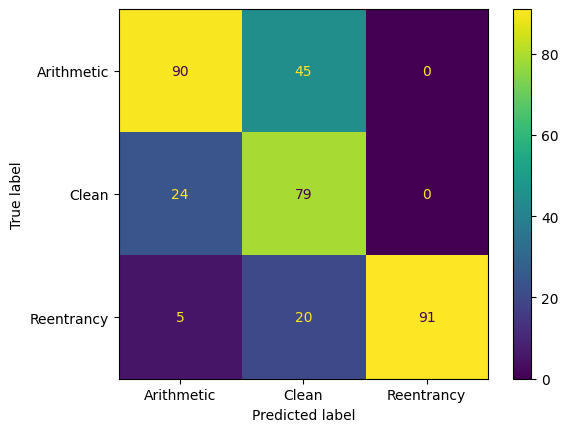

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_1, y_predicted_1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Arithmetic", "Clean", "Reentrancy"])

cm_display.plot()
plt.show()

In [ ]:
model.save('saved_model/mutil2_data')

In [ ]:
model1 = tf.keras.models.load_model('saved_model/mutil2_data')

In [ ]:
model1.fit([opcode_matrix, graph_train], y_train, epochs=10, batch_size=32)

Epoch 1/10
45/45 [==============================] - 10s 60ms/step - loss: 0.3628 - accuracy: 0.8511 - precision: 0.8135 - recall: 0.7180
Epoch 2/10
45/45 [==============================] - 2s 36ms/step - loss: 0.3607 - accuracy: 0.8473 - precision: 0.8070 - recall: 0.7124
Epoch 3/10
45/45 [==============================] - 1s 33ms/step - loss: 0.3367 - accuracy: 0.8582 - precision: 0.8208 - recall: 0.7350
Epoch 4/10
45/45 [==============================] - 1s 32ms/step - loss: 0.3540 - accuracy: 0.8490 - precision: 0.8071 - recall: 0.7187
Epoch 5/10
45/45 [==============================] - 1s 31ms/step - loss: 0.3448 - accuracy: 0.8563 - precision: 0.8192 - recall: 0.7300
Epoch 6/10
45/45 [==============================] - 1s 28ms/step - loss: 0.3235 - accuracy: 0.8594 - precision: 0.8231 - recall: 0.7364
Epoch 7/10
45/45 [==============================] - 1s 31ms/step - loss: 0.3219 - accuracy: 0.8641 - precision: 0.8379 - recall: 0.7343
Epoch 8/10
45/45 [=============================

In [ ]:
model1.evaluate([opcode_matrix_test, graph_test], y_test, verbose=1, batch_size=32)

12/12 [==============================] - 2s 13ms/step - loss: 0.3330 - accuracy: 0.8493 - precision: 0.7904 - recall: 0.7458


[0.3329889476299286,
 0.8493408560752869,
 0.7904191613197327,
 0.7457627058029175]

In [ ]:
y_predicted1 = model1.predict([opcode_matrix_test, graph_test], batch_size=32)
y_predicted1 = np.argmax(y_predicted1, axis=1)
y_test = np.argmax(y_test, axis=1)

12/12 [==============================] - 1s 11ms/step


In [ ]:
print(classification_report(y_test, y_predicted1))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74       135
           1       0.65      0.69      0.67       103
           2       0.97      0.84      0.90       116

    accuracy                           0.77       354
   macro avg       0.78      0.76      0.77       354
weighted avg       0.78      0.77      0.77       354



In [ ]:
print(accuracy_score(y_test, y_predicted1))

0.7655367231638418


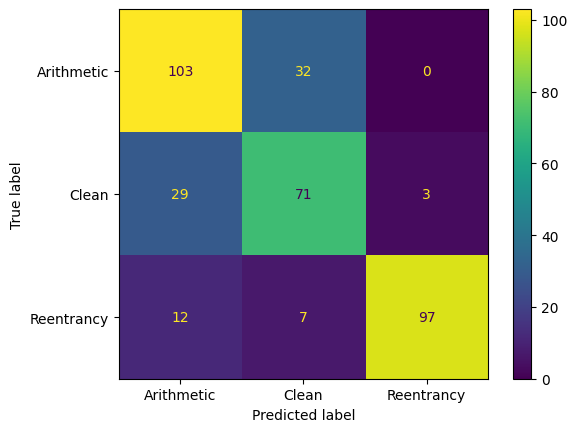

In [ ]:
cm = confusion_matrix(y_test, y_predicted1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Arithmetic", "Clean", "Reentrancy"])

cm_display.plot()
plt.show()

In [ ]:
model1.save('saved_model/mutil2_data')

In [ ]:
model2 = tf.keras.models.load_model('saved_model/mutil2_data')

In [ ]:
model2.fit([opcode_matrix, graph_train], y_train, epochs=10, batch_size=32)

Epoch 1/10
45/45 [==============================] - 10s 62ms/step - loss: 0.2844 - accuracy: 0.8749 - precision: 0.8459 - recall: 0.7640
Epoch 2/10
45/45 [==============================] - 2s 39ms/step - loss: 0.2770 - accuracy: 0.8751 - precision: 0.8417 - recall: 0.7703
Epoch 3/10
45/45 [==============================] - 1s 31ms/step - loss: 0.2647 - accuracy: 0.8853 - precision: 0.8608 - recall: 0.7823
Epoch 4/10
45/45 [==============================] - 1s 32ms/step - loss: 0.2758 - accuracy: 0.8843 - precision: 0.8626 - recall: 0.7767
Epoch 5/10
45/45 [==============================] - 1s 33ms/step - loss: 0.2622 - accuracy: 0.8850 - precision: 0.8630 - recall: 0.7788
Epoch 6/10
45/45 [==============================] - 2s 39ms/step - loss: 0.2370 - accuracy: 0.8985 - precision: 0.8838 - recall: 0.8007
Epoch 7/10
45/45 [==============================] - 1s 32ms/step - loss: 0.2478 - accuracy: 0.8949 - precision: 0.8818 - recall: 0.7908
Epoch 8/10
45/45 [=============================

In [ ]:
y_test2 = df_test['label'].values
y_test2 = to_categorical(y_test2)

In [ ]:
model2.evaluate([opcode_matrix_test, graph_test], y_test2, verbose=1, batch_size=32)

12/12 [==============================] - 2s 13ms/step - loss: 0.4321 - accuracy: 0.8465 - precision: 0.7851 - recall: 0.7429


[0.4321110248565674,
 0.8465160131454468,
 0.7850746512413025,
 0.7429378628730774]

In [ ]:
import numpy as np
y_predicted2 = model2.predict([opcode_matrix_test, graph_test], batch_size=32)
y_predicted2 = np.argmax(y_predicted2, axis=1)
y_test2 = np.argmax(y_test2, axis=1)

12/12 [==============================] - 1s 13ms/step


In [ ]:
print(classification_report(y_test2, y_predicted2))

              precision    recall  f1-score   support

           0       0.70      0.79      0.75       135
           1       0.69      0.57      0.63       103
           2       0.87      0.88      0.88       116

    accuracy                           0.76       354
   macro avg       0.76      0.75      0.75       354
weighted avg       0.76      0.76      0.75       354



In [ ]:
print(accuracy_score(y_test2, y_predicted2))

0.7570621468926554


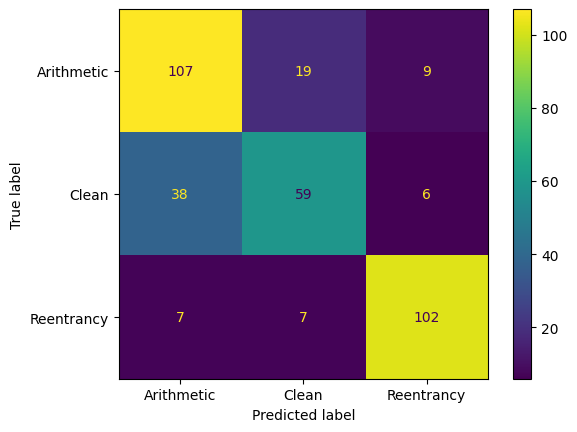

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test2, y_predicted2)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Arithmetic", "Clean", "Reentrancy"])

cm_display.plot()
plt.savefig("/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Figure/KLTN/Multimodal2_30.png", dpi=1200, transparent=True)
plt.show()